In [90]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from pathlib import Path

In [91]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [92]:
# Unzip dataset
!unzip '/content/gdrive/My Drive/FoodRecognition.zip' 

Archive:  /content/gdrive/My Drive/FoodRecognition.zip
replace test/apple/Image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [93]:
dataset_dir = '/content/DATASET'

# Path untuk dataset train, test, dan validation
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'validation')

In [94]:
def image_processing(filepath):
    labels = [os.path.basename(os.path.dirname(fp)) for fp in filepath]
    filepath_series = pd.Series(filepath, name='Filepath', dtype=str)
    labels_series = pd.Series(labels, name='Label', dtype=str)

    # Concatenate filepaths and labels
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [95]:
# Define image size and batch size
image_size = (128, 128)
batch_size = 32

In [96]:
# Get filepaths for training, testing, and validation
train_filepaths = [str(filepath) for filepath in Path(train_dir).rglob('*.jpg')]
test_filepaths = [str(filepath) for filepath in Path(test_dir).rglob('*.jpg')]
val_filepaths = [str(filepath) for filepath in Path(val_dir).rglob('*.jpg')]

In [97]:
# Process the filepaths
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [98]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['peas' 'corn' 'capsicum' 'pomegranate' 'cauliflower' 'sweetpotato'
 'mango' 'raddish' 'watermelon' 'eggplant' 'spinach' 'tomato' 'pear'
 'grapes' 'turnip' 'chilli pepper' 'garlic' 'apple' 'sweetcorn'
 'pineapple' 'carrot' 'banana' 'lettuce' 'potato' 'cucumber' 'paprika'
 'kiwi' 'jalepeno' 'ginger' 'orange' 'lemon' 'cabbage' 'beetroot'
 'bell pepper' 'onion' 'soy beans']


In [99]:
train_df.head(5)

,Filepath,Label
0,/content/DATASET/train/peas/Image_49.jpg,peas
1,/content/DATASET/train/corn/Image_29.jpg,corn
2,/content/DATASET/train/capsicum/Image_15.jpg,capsicum
3,/content/DATASET/train/pomegranate/Image_29.jpg,pomegranate
4,/content/DATASET/train/cauliflower/Image_30.jpg,cauliflower


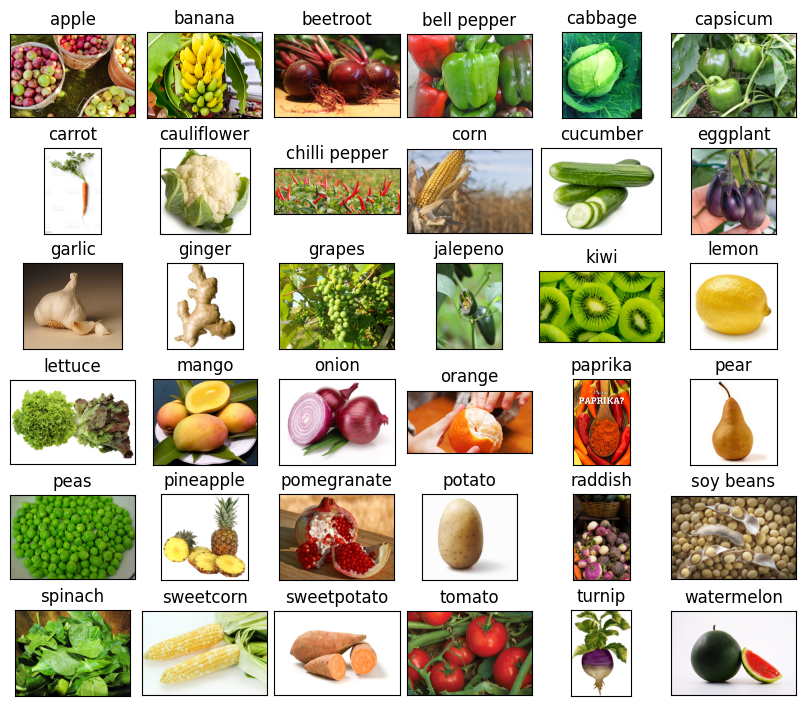

In [100]:
# Randomly select one image per category
df_unique = train_df.groupby("Label").first().reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=12)
plt.tight_layout(pad=0.5)
plt.show()

In [101]:
# Load and preprocess images
def preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.resize(image, image_size)
    image = image / 255.0
    return image

In [102]:
X_train = []
y_train = []
for filepath in train_df['Filepath']:
    try:
        image = preprocess_image(filepath)
        X_train.append(image)
        label = train_df[train_df['Filepath'] == filepath]['Label'].values[0]
        y_train.append(label)
    except Exception as e:
        print(f"Error processing image {filepath}: {str(e)}")

Error processing image /content/DATASET/train/bell pepper/Image_56.jpg: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [103]:
labels = train_df['Label'].unique()
label_to_index = {label: index for index, label in enumerate(labels)}
X_train = np.array(X_train)
y_train = np.array([label_to_index[label] for label in y_train])

In [104]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [105]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [106]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    shuffle=True,
    target_size=image_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    shuffle=False,
    target_size=image_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    batch_size=batch_size,
    shuffle=False,
    target_size=image_size,
    class_mode='categorical'
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [107]:
# Model CNN nya
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labels), activation='softmax'))

In [108]:
# Kompile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [109]:
# Melatih model
history = model.fit(train_generator, epochs=1, validation_data=val_generator)

 4/87 [>.............................] - ETA: 2:45 - loss: 3.7032 - accuracy: 0.0469

KeyboardInterrupt: ignored

In [52]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

11/11 [==============================] - 29s 2s/step - loss: 0.3910 - accuracy: 0.9281
Test Loss: 0.3909927308559418
Test Accuracy: 0.9281437397003174


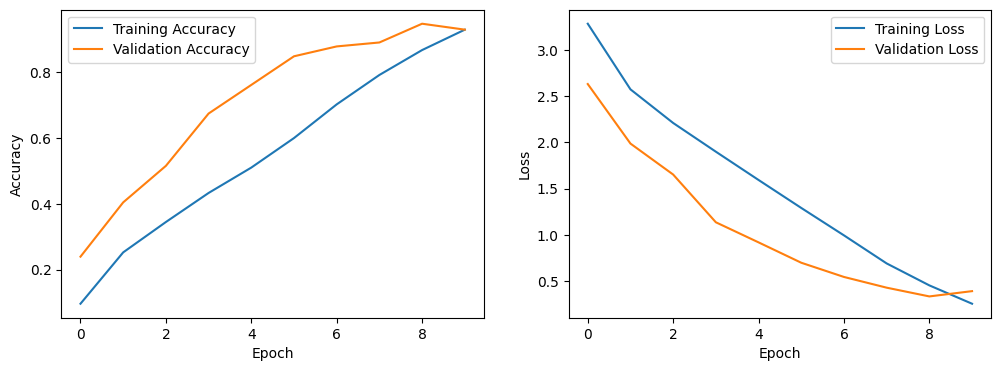

In [53]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
# Path to the image you want to test
test_image_path = '/content/istockphoto-185262648-612x612.jpg'

In [87]:
# Load and preprocess the test image
test_image = load_img(test_image_path, target_size=image_size)
test_image = img_to_array(test_image)
test_image = test_image / 255.0
test_image = np.expand_dims(test_image, axis=0)

In [88]:
# Predict the class of the test image
predictions = model.predict(test_image)
predicted_label = labels[np.argmax(predictions)]

1/1 [==============================] - 0s 51ms/step


In [89]:
# Display the predicted label
print('Predicted label:', predicted_label)

Predicted label: chilli pepper


In [ ]:
dataset_dir = '/content/Dataset'

new_image_paths = [
    os.path.join(dataset_dir, 'image1.jpg'),
    os.path.join(dataset_dir, 'image2.jpg'),
    os.path.join(dataset_dir, 'image3.jpg')
]

new_images = []
for image_path in new_image_paths:
    image = load_img(image_path, target_size=image_size)
    image = img_to_array(image)
    image = preprocess_image(image)
    new_images.append(image)

new_images = np.array(new_images)

In [ ]:
import os

dataset_dir = '/content/Dataset/validation'

new_image_paths = [
    os.path.join(dataset_dir, 'image1.jpg'),
    os.path.join(dataset_dir, 'image2.jpg'),
    os.path.join(dataset_dir, 'image3.jpg')
]

# Cek keberadaan file
for image_path in new_image_paths:
    if not os.path.exists(image_path):
        print(f"File not found: {image_path}")

In [ ]:
file_list = os.listdir(dataset_dir)
print(file_list)

In [ ]:
# Make predictions
predictions = loaded_model.predict(new_images)
predicted_labels = [labels[np.argmax(pred)] for pred in predictions]

print('Predictions:', predicted_labels)

In [ ]:
# Capture frame from the camera
cap = cv2.VideoCapture(0)

In [ ]:
# Define the class labels
class_labels = ['fruit', 'vegetable']

In [ ]:
# Define the calorie data
calorie_data = {
    'apple': 52,
    'banana': 96,
    'carrot': 41,
    'tomato': 18,
    # Add other fruits and vegetables along with their calorie values
}

In [ ]:
while True:
    ret, frame = cap.read()
    preprocessed_frame = preprocess_image(frame)
    input_image = np.expand_dims(preprocessed_frame, axis=0)
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)
    
    # Run inference
    interpreter.invoke()

In [ ]:
# Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_lite = class_labels[np.argmax(output_data)]

In [ ]:
# Display the predicted class on the frame
    cv2.putText(frame, predicted_class_lite, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

In [ ]:
# Calculate and display the calorie count
    if predicted_class_lite in calorie_data:
        calorie_count = calorie_data[predicted_class_lite]
        cv2.putText(frame, f"Calories: {calorie_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(frame, "Calorie count unavailable", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

In [ ]:
# Display the frame
    cv2.imshow('Object Detection (TensorFlow Lite)', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:
# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()

# Saving or Loading the Model
# Saving the model as TF Lite format
model.save('fruit_vegetable_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the TensorFlow Lite model
with open('fruit_vegetable_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='fruit_vegetable_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Perform prediction using TensorFlow Lite model
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    preprocessed_frame = preprocess_image(frame)
    input_image = np.expand_dims(preprocessed_frame, axis=0)

In [ ]:
# Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)
    
    # Run inference
    interpreter.invoke()
    
    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class_lite = class_labels[np.argmax(output_data)]

In [ ]:
# Display the predicted class on the frame
    cv2.putText(frame, predicted_class_lite, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

In [ ]:
# Calculate and display the calorie count
    if predicted_class_lite in calorie_data:
        calorie_count = calorie_data[predicted_class_lite]
        cv2.putText(frame, f"Calories: {calorie_count}", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(frame, "Calorie count unavailable", (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

In [ ]:
# Display the frame
    cv2.imshow('Object Detection (TensorFlow Lite)', frame)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()